# **Практическая работа №13**

### **Задание:**
Реализовать нейронную сеть для определения тональности высказываний

### **Решение:**
1. Набор данных – высказывания, для которых определены метки
тональности (6 классов: fear, anger, surprise, sadness, love, joy). В архиве
всего 3 файла.

In [37]:
"""
Необходимые библиотеки
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

In [38]:
%pip install pandarallel
%pip install nltk
%pip install ipywidgets
%pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
def open_file(PATH):
    """
    This function opens a file and returns a pandas dataframe (File is .txt)
    """
    # Columns are "text" and "label" separated by ;
    df = pd.read_csv(PATH, sep=';', names=['text', 'label'])
    return df

In [40]:
test_df = open_file("/kaggle/input/emotionality/test.txt")
train_df = open_file("/kaggle/input/emotionality/train.txt")
val_df = open_file("/kaggle/input/emotionality/val.txt")

In [41]:
val_df.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


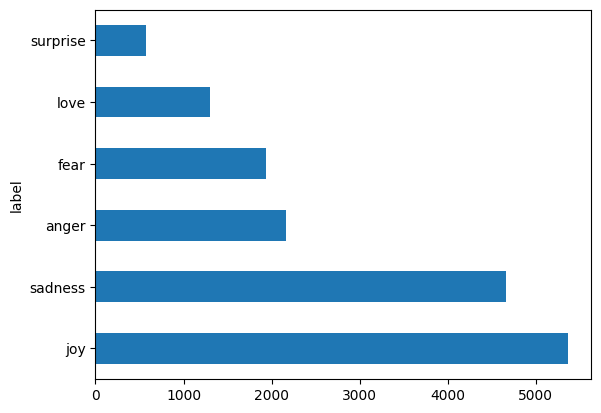

In [42]:
# Распределение классов в тренировочной выборке
train_df['label'].value_counts().plot(kind='barh')
plt.show()

2. Выполнить обработку данных также,как и с фильмами. Каждый текст
должен представлять из себя набор чисел. Каждое число – это слово в
частотном словаре всех слов текстов, отсортированных в порядке
невозрастания (то есть сначала в словаре располагаются самые частые
слова).

In [43]:
print(train_df.columns)
train_df.shape

Index(['text', 'label'], dtype='object')


(16000, 2)

In [44]:
x_train = train_df['text'].values
print(len(x_train))
print(f'A sample from x train : {x_train[10]}')

16000
A sample from x train : i feel like i have to make the suffering i m seeing mean something


In [45]:
print("unique values : ",train_df.label.unique())
y_train = train_df['label'].values
print(y_train[:5])
one = OneHotEncoder(sparse = False)
one.fit(y_train.reshape(len(y_train),1))
y_train = one.transform(y_train.reshape(len(y_train),1))
print(y_train[:5])

unique values :  ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']
['sadness' 'sadness' 'anger' 'love' 'anger']
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
test_df.columns = ['text','label']
val_df.columns = ['text','label']
x_test = test_df['text'].values
print(len(x_test))
x_val = val_df['text'].values
print(len(x_val))



y_test = test_df['label'].values
one.fit(y_test.reshape(len(y_test),1))
y_test = one.transform(y_test.reshape(len(y_test),1))


y_val = val_df['label'].values
one.fit(y_val.reshape(len(y_val),1))
y_val = one.transform(y_val.reshape(len(y_val),1))

2000
2000


/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
vocab_size = 1000
oov = '<OOV>'
max_length = 50
truc_type ='post'

In [48]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
print(f'same sample after tokenizing : {x_train[10]}')

same sample after tokenizing : [2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]


In [49]:
word_index = tokenizer.word_index
{key: word_index[key] for key in list(word_index)[:10]}

{'<OOV>': 1,
 'i': 2,
 'feel': 3,
 'and': 4,
 'to': 5,
 'the': 6,
 'a': 7,
 'feeling': 8,
 'that': 9,
 'of': 10}

In [50]:
x_train = pad_sequences(x_train,padding='pre',maxlen=max_length,truncating = 'post')
x_train.shape

(16000, 50)

In [51]:
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test,padding='pre',maxlen=max_length,truncating = 'post')
print(x_test.shape)

x_val = tokenizer.texts_to_sequences(x_val)
x_val = pad_sequences(x_val,padding='pre',maxlen=max_length,truncating = 'post')
print(x_val.shape)

(2000, 50)
(2000, 50)


In [52]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Embedding, Bidirectional
#creating the RNN model using SimpleRNN

model = Sequential()
#embedding layer to vectorize
model.add(Embedding(vocab_size,output_dim = 64))

#simpleRNN layer
model.add(SimpleRNN(64,activation='relu'))

#dense layer
model.add(Dense(32,activation='relu'))
model.add(Dense(6,activation='softmax'))
print(model.summary())
opt = tf.keras.optimizers.Adam()

#compile
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          64000     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 6)                 198       
                                                                 
Total params: 74534 (291.15 KB)
Trainable params: 74534 (291.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [53]:
history = model.fit(x_train,y_train,epochs = 10,validation_data=(x_val,y_val))

Epoch 1/10
500/500 [==============================] - 6s 10ms/step - loss: 1.4031 - accuracy: 0.4227 - val_loss: 1.0122 - val_accuracy: 0.6380
Epoch 2/10
500/500 [==============================] - 5s 10ms/step - loss: 0.7396 - accuracy: 0.7121 - val_loss: 0.6680 - val_accuracy: 0.7470
Epoch 3/10
500/500 [==============================] - 5s 9ms/step - loss: 0.5571 - accuracy: 0.7879 - val_loss: 0.5383 - val_accuracy: 0.7885
Epoch 4/10
500/500 [==============================] - 5s 9ms/step - loss: 0.4510 - accuracy: 0.8347 - val_loss: 0.4457 - val_accuracy: 0.8440
Epoch 5/10
500/500 [==============================] - 4s 9ms/step - loss: 0.3552 - accuracy: 0.8732 - val_loss: 0.4412 - val_accuracy: 0.8545
Epoch 6/10
500/500 [==============================] - 4s 9ms/step - loss: 0.3032 - accuracy: 0.8889 - val_loss: 0.4732 - val_accuracy: 0.8430
Epoch 7/10
500/500 [==============================] - 5s 9ms/step - loss: 0.2749 - accuracy: 0.8965 - val_loss: 0.4036 - val_accuracy: 0.8600
Epoc

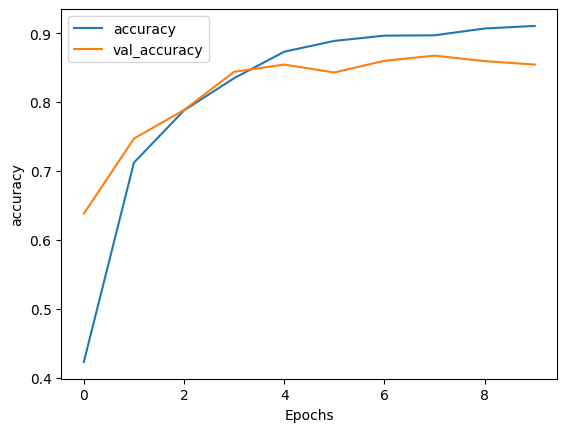

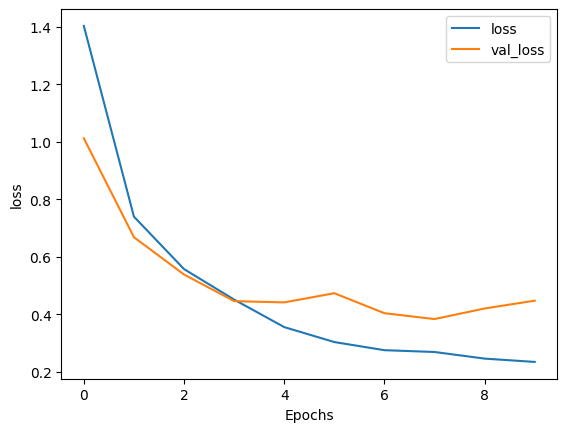

In [54]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy')

plot_graphs(history, 'loss')

In [55]:
loss,acc = model.evaluate(x_test,y_test)
print(f"Test accuracy is {acc*100}%")

63/63 [==============================] - 0s 4ms/step - loss: 0.3840 - accuracy: 0.8685
Test accuracy is 86.84999942779541%


In [56]:
#creating the RNN model using LSTM

model = Sequential()
#embedding layer to vectorize
model.add(Embedding(vocab_size,output_dim = 64))

#simpleRNN layer
model.add(LSTM(64,activation='relu'))

#dense layer

model.add(Dense(32,activation='relu'))
model.add(Dense(6,activation='softmax'))
print(model.summary())
opt = tf.keras.optimizers.Adam()

#compile
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 6)                 198       
                                                                 
Total params: 99302 (387.90 KB)
Trainable params: 99302 (387.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [57]:
history = model.fit(x_train,y_train,epochs = 10,validation_data=(x_val,y_val))

Epoch 1/10
500/500 [==============================] - 11s 20ms/step - loss: 2.0120 - accuracy: 0.4329 - val_loss: 3.7210 - val_accuracy: 0.5805
Epoch 2/10
500/500 [==============================] - 9s 18ms/step - loss: 4.5086 - accuracy: 0.6129 - val_loss: 1.0903 - val_accuracy: 0.6360
Epoch 3/10
500/500 [==============================] - 9s 19ms/step - loss: 1.3299 - accuracy: 0.6217 - val_loss: 0.9999 - val_accuracy: 0.6325
Epoch 4/10
500/500 [==============================] - 9s 18ms/step - loss: 0.9602 - accuracy: 0.6492 - val_loss: 0.9950 - val_accuracy: 0.6475
Epoch 5/10
500/500 [==============================] - 9s 18ms/step - loss: 0.9221 - accuracy: 0.6796 - val_loss: 0.8475 - val_accuracy: 0.7170
Epoch 6/10
500/500 [==============================] - 9s 17ms/step - loss: 0.6776 - accuracy: 0.7656 - val_loss: 0.6490 - val_accuracy: 0.7980
Epoch 7/10
500/500 [==============================] - 9s 18ms/step - loss: 0.5001 - accuracy: 0.8303 - val_loss: 0.5145 - val_accuracy: 0.825

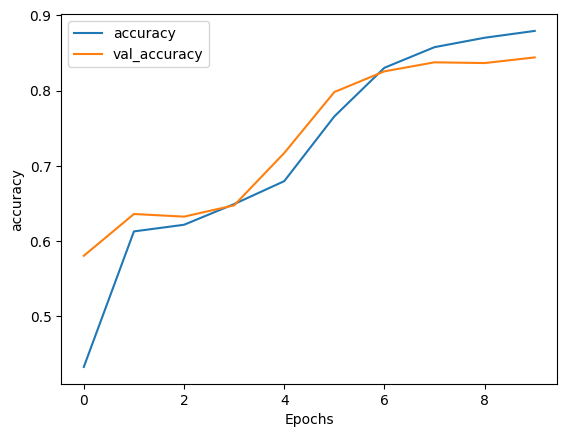

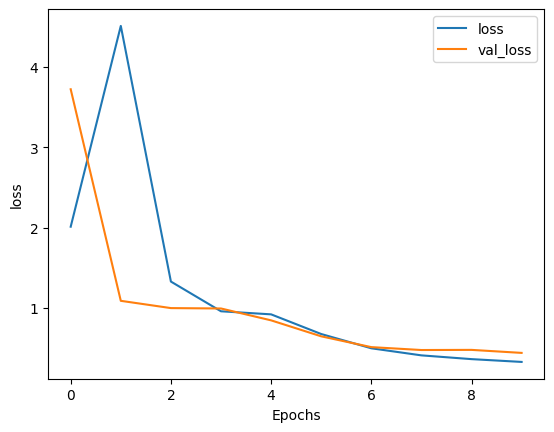

In [58]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [59]:
loss,acc = model.evaluate(x_test,y_test)
print(f"Test accuracy is {acc*100}%")

63/63 [==============================] - 0s 8ms/step - loss: 0.4118 - accuracy: 0.8530
Test accuracy is 85.29999852180481%


In [60]:
#introducing a  Bidirectional LSTM
model = Sequential()
#embedding layer to vectorize
model.add(Embedding(vocab_size,output_dim = 64))

#simpleRNN layer
model.add(Bidirectional(LSTM(64,activation='relu')))

#dense layer

model.add(Dense(32,activation='relu'))
model.add(Dense(6,activation='softmax'))
print(model.summary())
opt = tf.keras.optimizers.Adam()

#compile
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 6)                 198       
                                                                 
Total params: 134374 (524.90 KB)
Trainable params: 134374 (524.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Epoch 1/10
500/500 [==============================] - 13s 23ms/step - loss: 1.4840 - accuracy: 0.4666 - val_loss: 1.0784 - val_accuracy: 0.6105
Epoch 2/10
500/500 [==============================] - 11s 21ms/step - loss: 1.1692 - accuracy: 0.6293 - val_loss: 0.9351 - val_accuracy: 0.6460
Epoch 3/10
500/500 [==============================] - 10s 20ms/step - loss: 0.7453 - accuracy: 0.7213 - val_loss: 0.6739 - val_accuracy: 0.7530
Epoch 4/10
500/500 [==============================] - 11s 22ms/step - loss: 0.5476 - accuracy: 0.8066 - val_loss: 0.5266 - val_accuracy: 0.8180
Epoch 5/10
500/500 [==============================] - 11s 21ms/step - loss: 0.4286 - accuracy: 0.8468 - val_loss: 0.5034 - val_accuracy: 0.8260
Epoch 6/10
500/500 [==============================] - 10s 20ms/step - loss: 0.3762 - accuracy: 0.8624 - val_loss: 0.5131 - val_accuracy: 0.8415
Epoch 7/10
500/500 [==============================] - 11s 21ms/step - loss: 5170.8076 - accuracy: 0.8544 - val_loss: 0.4340 - val_accura

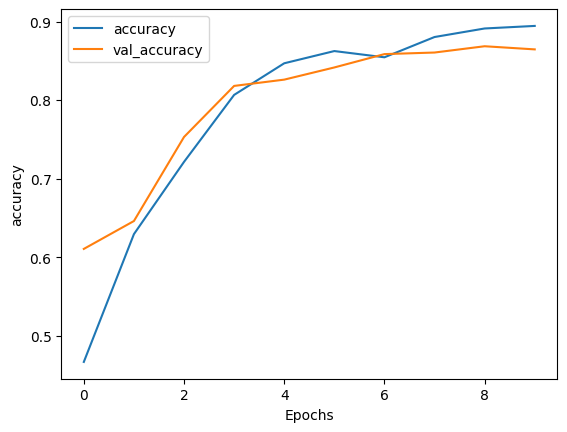

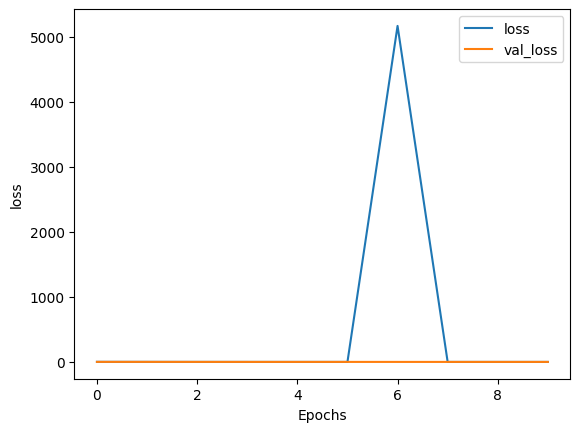

In [61]:
history = model.fit(x_train,y_train,epochs = 10,validation_data=(x_val,y_val))
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [62]:
loss,acc = model.evaluate(x_test,y_test)
print(f"Test accuracy is {acc*100}%")

63/63 [==============================] - 1s 8ms/step - loss: 0.3708 - accuracy: 0.8675
Test accuracy is 86.75000071525574%
